### CSV formatting

In [32]:
from pandas import concat
from pandas import read_csv

splits_files = list((base_path / 'datasets').glob('*.csv'))
dvh_files = [filename for filename in splits_files if 'DvH' in filename.name]
dvp_files = [filename for filename in splits_files if 'DvP' in filename.name]
hvp_files = [filename for filename in splits_files if 'HvP' in filename.name]

def load_and_concat(files):
    dfs = []
    for file in files:
        df = read_csv(file)
        df['split'] = file.stem.split('_')[-3]
        df = rearrange_columns(df)
        dfs.append(df)
    return concat(dfs, ignore_index=True)

def rearrange_columns(df):
    df = df.rename(columns={'age_at_image': 'age_at_scan'})
    df = df.drop(columns=['index', 'target', 'group'])
    df['image_path'] = df['image_path'].apply(lambda pth: str(pth).replace('/dccstor/fs_processing/xls-data_temp/', ''))
    df['image_path'] = df['image_path'].apply(lambda pth: pth.split('/')[0] + '/images_rigid/' + pth.split('/')[1])
    df['dataset'] = df['image_path'].apply(lambda pth: pth.split('/')[0])
    return df

def save_metadata_and_splits(df, data_name, base_path):
    metadata_path = base_path / data_name / 'metadata' / f'{data_name}_image_baseline_metadata.csv'
    splits_path = base_path / data_name / 'splits'
    splits_path.mkdir(parents=True, exist_ok=True)
    metadata_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(metadata_path, index=False)
    train_split = df[df['split'] == 'train']
    val_split = df[df['split'] == 'val']
    train_split.to_csv(splits_path / 'train.csv', index=False)
    val_split.to_csv(splits_path / 'val.csv', index=False)


dvh_df = load_and_concat(dvh_files)
dvp_df = load_and_concat(dvp_files)
hvp_df = load_and_concat(hvp_files)
save_metadata_and_splits(dvh_df, 'ad_vs_hc', base_path / 'datasets')
save_metadata_and_splits(dvp_df, 'ad_vs_mci', base_path / 'datasets')
save_metadata_and_splits(hvp_df, 'mci_vs_hc', base_path / 'datasets')

## RDMs analysis

### Helper methods

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rsa_histogram_grid(compared_rdms, layer, task):
    compared_rdms = compared_rdms[task]
    x_models = [model for model in compared_rdms.keys() if 'pretrained' in model]
    y_model_pairs = [(f'{y_model.split('_')[0]}_pretrained', f'{y_model.split('_')[0]}_tl') for y_model in x_models]
    
    sns.set_theme()
    fig, axes = plt.subplots(len(y_model_pairs), len(x_models), figsize=(10, 8))
    fig.tight_layout(pad=3.0)
    
    plt.subplots_adjust(top=0.9)
    parsed_task_title = task.replace('ad_vs_hc', 'AD and HC')
    parsed_task_title = parsed_task_title.replace('ad_vs_mci', 'AD and MCI')
    parsed_task_title = parsed_task_title.replace('mci_vs_hc', 'MCI and HC')
    fig.suptitle(f'RSA Analysis on {parsed_task_title} subjects for layer {layer}', fontsize=14)

    all_values = []
    for x_model in x_models:
        for y_pretrained, y_finetuned in y_model_pairs:
            all_values.extend(compared_rdms[x_model][y_pretrained][layer])
            all_values.extend(compared_rdms[x_model][y_finetuned][layer])
    global_min = min(all_values)
    global_max = max(all_values)
    padding = (global_max - global_min) * 0.05
    global_min -= padding
    global_max += padding
    
    # Add column labels (x-axis models)
    for col, x_model in enumerate(x_models):
        model_name = x_model.split('_')[0]
        if model_name == 'bmi': model_name = 'BMI'
        col_title = f'Similarity to {model_name} prediction model'
        axes[0, col].set_title(col_title, fontsize=11)
    
    # Add row labels (y-axis model pairs)
    for row, (pretrained, _) in enumerate(y_model_pairs):
        model_name = pretrained.split('_')[0].capitalize()
        if model_name == 'Bmi': model_name = 'BMI'
        ylabel = f'{model_name} prediction\n before and after fine-tuning'
        axes[row, 0].set_ylabel(ylabel, fontsize=10)
    
    # Set common x and y labels
    fig.text(0.5, 0.02, 'Correlation value', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Similarity density', va='center', rotation='vertical', fontsize=14)
    
    pretrained_color = sns.color_palette()[0]
    finetuned_color = sns.color_palette()[1]
    for row, (y_pretrained, y_finetuned) in enumerate(y_model_pairs):
        for col, x_model in enumerate(x_models):
            ax = axes[row, col]
            ax.set_yticks([])
            if col > 0:
                ax.set_yticklabels([])
            if row < len(y_model_pairs) - 1:
                ax.set_xticks([])
            else:
                ax.tick_params(axis='x', labelsize=10)

            pretrained_data = compared_rdms[x_model][y_pretrained][layer]
            finetuned_data = compared_rdms[x_model][y_finetuned][layer]
            if row != col:            
                sns.kdeplot(pretrained_data, ax=ax, fill=True, alpha=0.5, color=pretrained_color,
                        label=f'vs {y_pretrained}', linewidth=1, bw_adjust=0.8, legend=False)
            else:
                ax.axvline(x=1, color=pretrained_color, lw=2, alpha=0.7)
            sns.kdeplot(finetuned_data, ax=ax, fill=True, alpha=0.5, color=finetuned_color,
                      label=f'vs {y_finetuned}', linewidth=1, bw_adjust=0.8, legend=False)

            ax.set_xlim(global_min, global_max)
            ax.grid(alpha=0.3)

    handles = [
        plt.Line2D([0], [0], color=pretrained_color, lw=4, alpha=0.7),
        plt.Line2D([0], [0], color=finetuned_color, lw=4, alpha=0.7)
    ]
    labels = ['Pretrained', 'Fine-tuned']
    fig.legend(handles, labels, fontsize=10, frameon=True, loc='upper left')
    
    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])  # Adjust the rect parameter to make room for labels
    
    return fig

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations


def base_name(model_name):
    basename = model_name.split('_')[0]
    if basename == 'bmi':
        return 'BMI'
    elif basename == 'baseline':
        return 'Voxel Representation'
    return basename.capitalize() 


def plot_model_comparisons(comparisons_dict, model_type, layers='all', x_label='Layers', group_by='layer', legend=True, title=None,
                           fig_size=(10, 8)):
    """
    Plot correlation comparisons between models using strip plots with confidence intervals.
    
    Parameters:
    comparisons_dict: Dictionary with structure model1 -> model2 -> layer -> correlations
    model_type: Either 'pretrained' or 'tl' to specify which model versions to compare
    """
    models = [key for key in comparisons_dict.keys() if key.endswith(f'_{model_type}')]
    if model_type == 'tl':
        models += [f'baseline_{model_type}']
    model_pairs = list(combinations(models, 2))
    # order the model pairs to ensure "none" comparisons are first, then the others and finally the baseline
    model_pairs = sorted(model_pairs, key=lambda x: ('none' in x[0].lower(), 'none' in x[1].lower(), x[0], x[1]))
    # ensure baseline is always last
    model_pairs = [pair for pair in model_pairs if 'baseline' not in pair[0] and 'baseline' not in pair[1]] + \
                  [pair for pair in model_pairs if 'baseline' in pair[0] or 'baseline' in pair[1]]
    
    if layers == 'all':
        first_comparison = next(iter(comparisons_dict.values()))
        first_layer_dict = next(iter(first_comparison.values()))
        layers = list(first_layer_dict.keys())
    if not isinstance(layers, list):
        raise ValueError("Layers should be a list of layer names or 'all' to use all available layers.")
    
    data_rows = []
    for layer in layers:
        for model1, model2 in model_pairs:            
            if model1 in comparisons_dict and model2 in comparisons_dict[model1]:
                correlations = comparisons_dict[model1][model2][layer]
            elif model2 in comparisons_dict and model1 in comparisons_dict[model2]:
                correlations = comparisons_dict[model2][model1][layer]
            else:
                continue
            
            comparison = f"{base_name(model1)} vs {base_name(model2)}"
            if 'none' in model1.lower() or 'none' in model2.lower():
                group = 'non-pretrained'
            elif 'baseline' in model1.lower() or 'baseline' in model2.lower():
                group = 'voxel model'
            else:
                group = 'pretrained'
            for corr in correlations:
                data_rows.append({
                    'layer': layer,
                    'comparison': comparison,
                    'correlation': corr,
                    'group': group
                })
    
    df = pd.DataFrame(data_rows)
    color_map = sns.color_palette("deep")
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=fig_size)
    
    if group_by == 'layer':
        x = 'layer'
    else:
        x = 'group'

    ax = sns.boxplot(data=df, x=x, y='correlation', hue='comparison', linewidth=1.5, 
                palette=color_map, fliersize=0.0, legend=legend)
    sns.stripplot(data=df, x=x, y='correlation', hue='comparison', alpha=0.4, size=4, 
                  jitter=True, palette=color_map, dodge=True, ax=ax, legend=legend)

    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel('Correlation Values', fontsize=15)
    if title:
        ax.set_title(title, fontsize=16)
    else:
        ax.set_title(f'{model_type.capitalize()} modalities', fontsize=16)
    sns.despine(ax=ax, left=True)
    
    min_value = round(df['correlation'].min() - 0.05, 1)
    plt.yticks(np.arange(min_value, 1.01, 0.1))

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        n_comparisons = len(model_pairs)
        ax.legend(handles[:n_comparisons], labels[:n_comparisons], ncol=n_comparisons,
                title='Comparisons', loc='lower center', # bbox_to_anchor=(1.05, 1)
                )
    
    fig.patch.set_alpha(0.0)
    plt.tight_layout()
    plt.show()
    return fig

### Compute comparisons

In [ ]:
from pretrain_exp.rsa import compare_models, plot_maps, plot_correlations, load_task_rdms
from pathlib import Path

base_path = Path('pretrain_exp')
rdms_file, batches_file = 'rdms.pkl', 'batches.pkl'
rdms_path = base_path / 'results'
tasks = ['ad_vs_hc', 'ad_vs_mci', 'mci_vs_hc']
models = ['age', 'sex', 'bmi', 'none']
layers = ['conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5']
n_iters = 1000
random_state = 42
comparisons_dict = compare_models(tasks, models, layers, rdms_path, n_iters, random_state)

### AD vs. HC

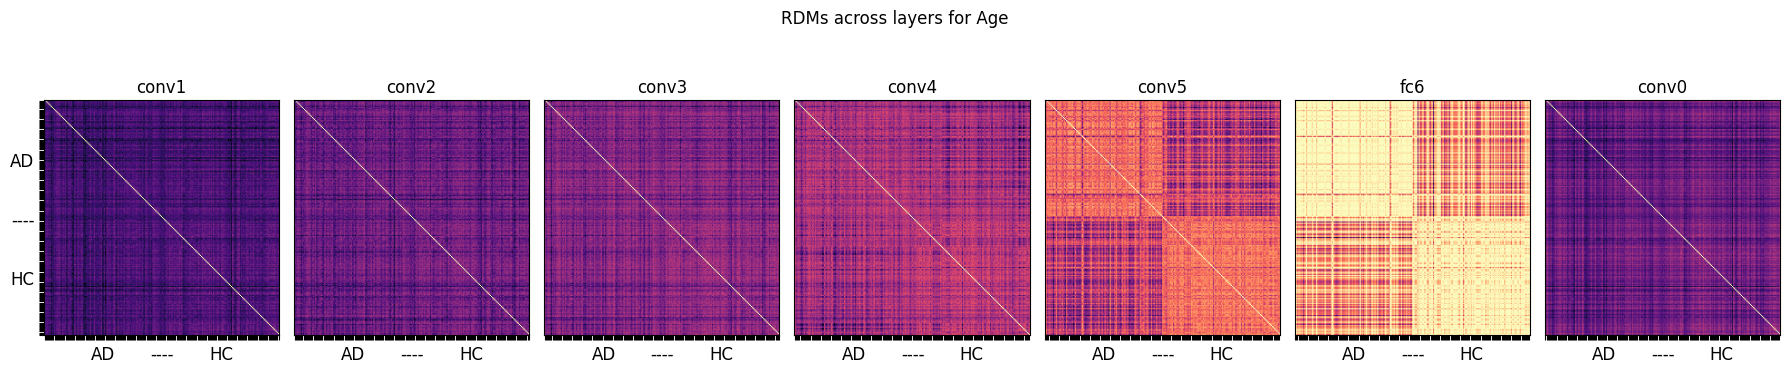

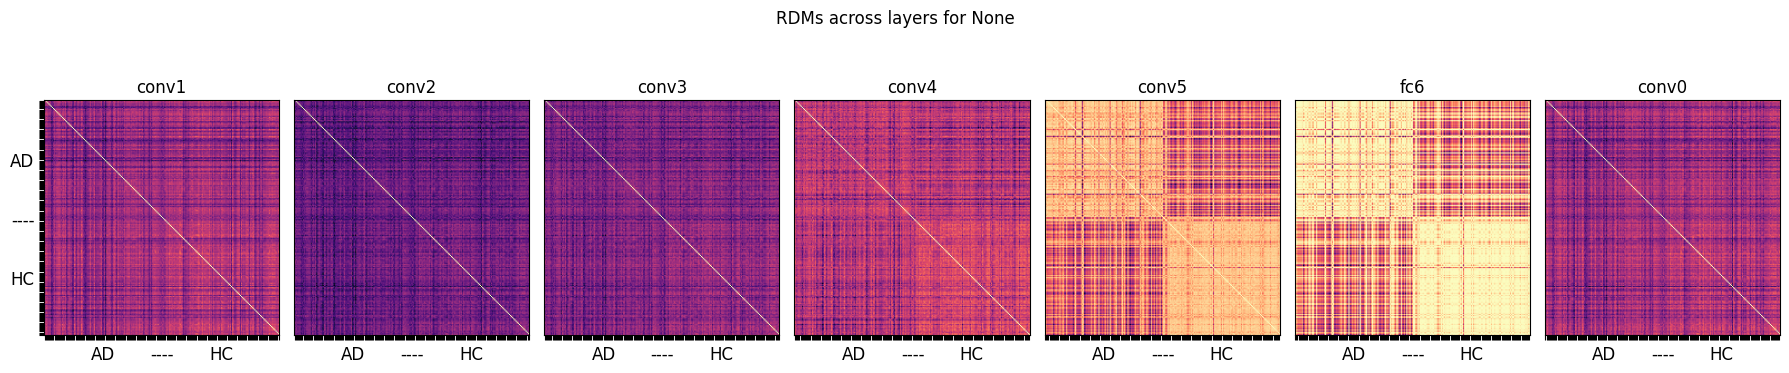

In [5]:
ad_vs_hc_rdms, _ = load_task_rdms(rdms_path, 'ad_vs_hc')
age_ft_rdms = plot_maps(ad_vs_hc_rdms['age']['tl'], 'Age', ['AD', 'HC'])
none_rdms = plot_maps(ad_vs_hc_rdms['none']['tl'], 'None', ['AD', 'HC'])
# tl_age_maps = plot_maps(ad_vs_hc_rdms['age']['tl'], 'Age TL', ['AD', 'HC'])
# tl_age_maps.savefig(rdms_path / 'tl_age_maps.png', dpi=300)

#### No finetuning

/tmp/ipykernel_184771/2195782845.py:78: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(data=df, x=x, y='correlation', hue='comparison', linewidth=1.5,
/tmp/ipykernel_184771/2195782845.py:80: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data=df, x=x, y='correlation', hue='comparison', alpha=0.4, size=4,


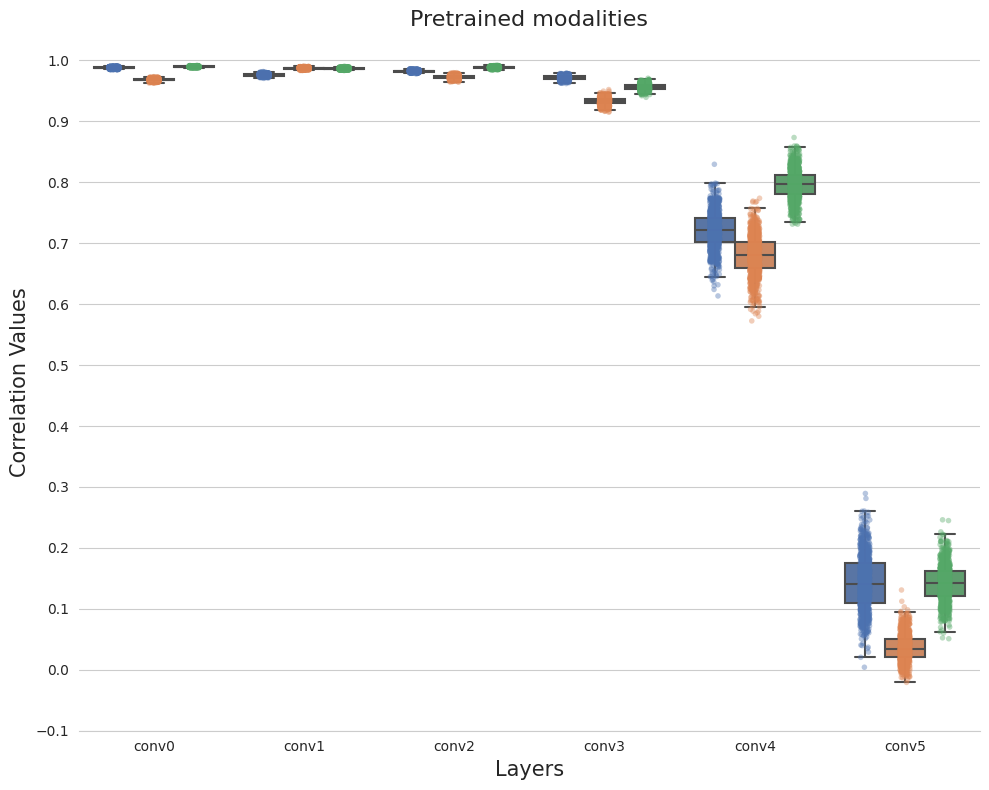

In [6]:
fig = plot_model_comparisons(comparisons_dict['ad_vs_hc'], model_type='pretrained', legend=False)
# fig.savefig('ad_vs_hc_pretrained_comparisons.png', dpi=300)

#### Finetuned modalities

/tmp/ipykernel_184771/2195782845.py:102: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


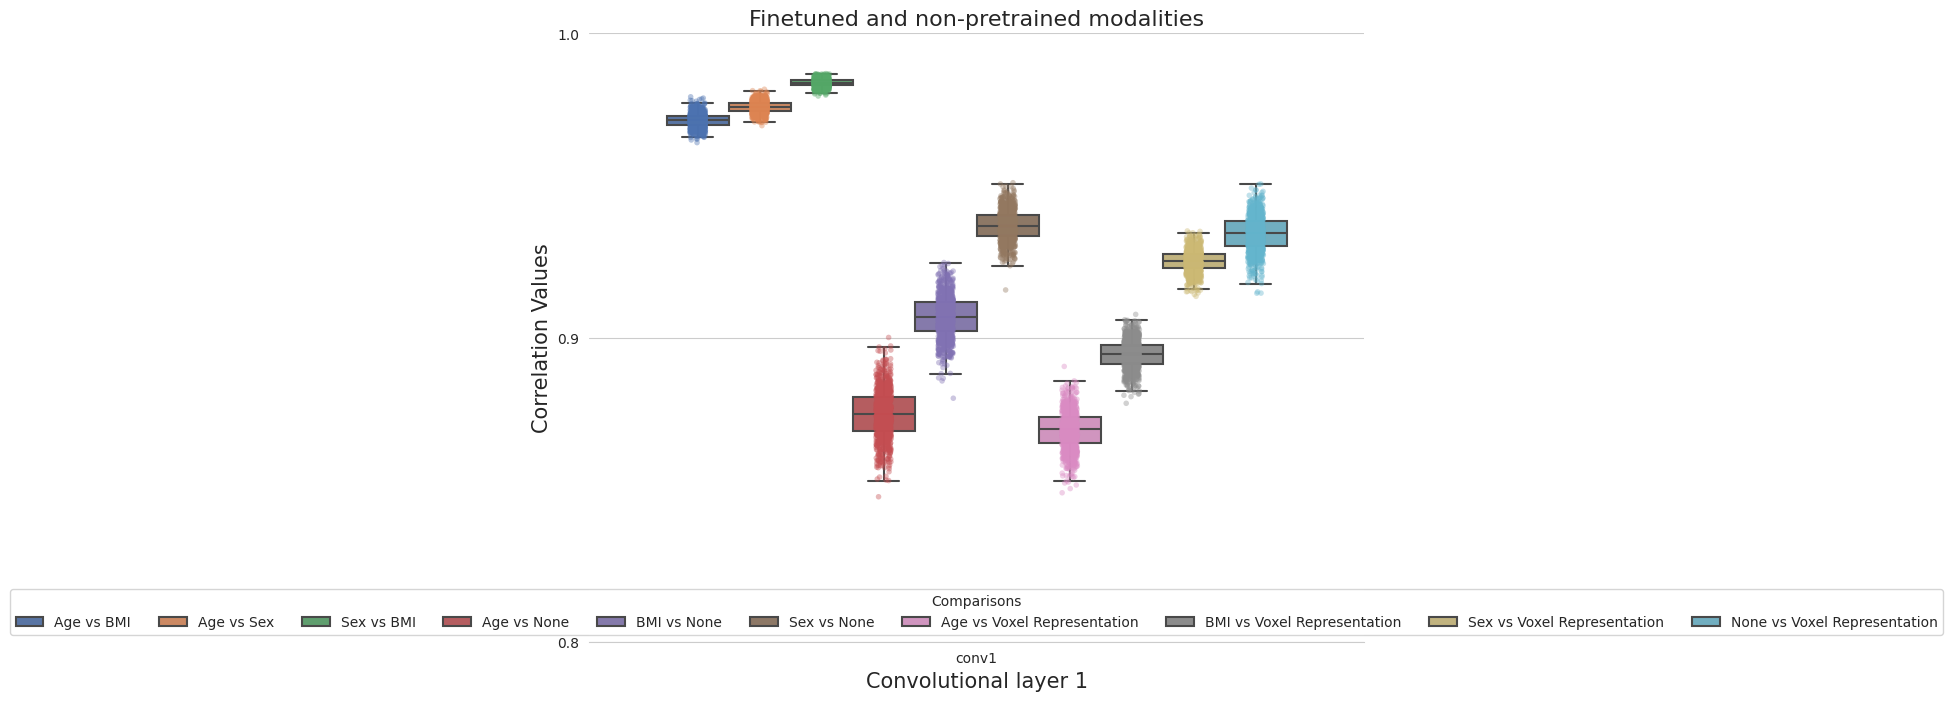

In [14]:
fig = plot_model_comparisons(comparisons_dict['ad_vs_hc'], model_type='tl', layers=['conv1'], legend=True, 
                             x_label='Convolutional layer 1', title='Finetuned and non-pretrained modalities',
                             fig_size=(10, 7.9))
# fig.savefig('ad_vs_hc_tl_comparisons.png', dpi=300)

### Histogram similarity grid plot

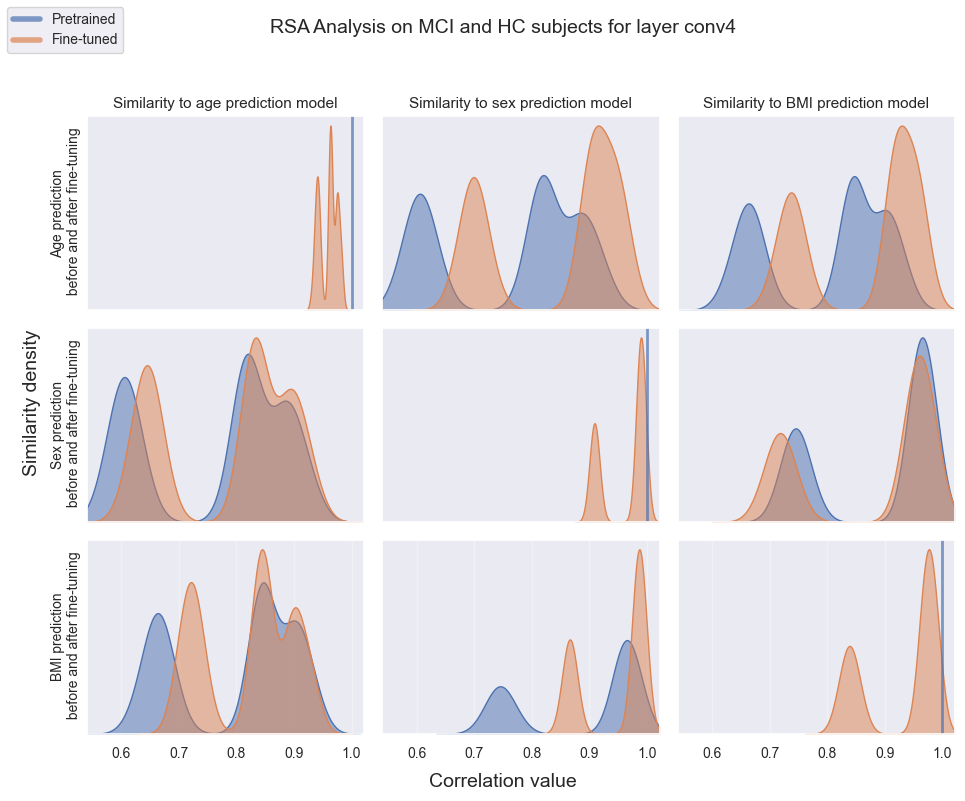

In [11]:
layer, task = 'conv4', 'mci_vs_hc'
fig = plot_rsa_histogram_grid(comparisons_dict, layer, task=task)
fig.savefig(base_path / 'results' / f'rsa_histogram_{task}_{layer}.png', dpi=300, bbox_inches='tight')
plt.show()